In [1]:
from transformers import pipeline

import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

import pandas as pd

import pickle

/Users/daniel/opt/anaconda3/envs/daniel-uni-python-38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-06 19:25:57.119149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


## Step 1:  Resize images to 256x256 and remove non-interested labels (!=8)

In [2]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/masks_resized/'

# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

(256, 256, 3)
(256, 256)
(200, 256, 256, 3)
(200, 256, 256)


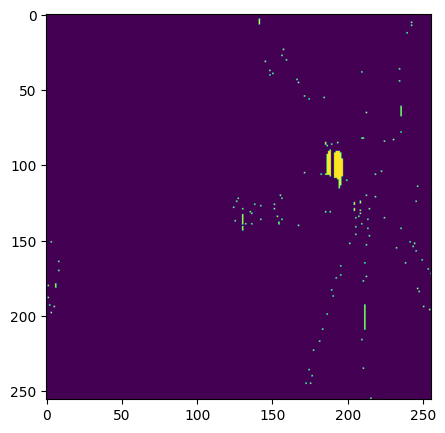

In [3]:
plt.figure(figsize = (10,5))
label_of_interest = 8 #veg

image_dataset = []
mask_dataset = []
for i in range(200):
    image = Image.open(path_images+tram_dict['filename_jpg'][i]).resize((256,256),3)
    mask = Image.open(path_masks+tram_dict['filename_mask'][i]).resize((256,256))
    image.save(path_images_resized+tram_dict['filename_jpg'][i])
    mask.save(path_masks_resized+tram_dict['filename_mask'][i])

    
    image = np.array(image)
    mask = np.array(mask)
    
    # VEG-FOCUSED mask
    mask[mask!=label_of_interest]=0
    mask[mask==label_of_interest]=1

    image_dataset.append(image)
    mask_dataset.append(mask)


# convert from list of array to array
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

pickle.dump(image_dataset, open('image_dataset_200', "wb"))
pickle.dump(mask_dataset, open('mask_dataset_200', "wb"))


print(image.shape)
print(mask.shape)
print(image_dataset.shape)
print(mask_dataset.shape)
plt.imshow(mask)


## Step 2: Create depth estimation mask

In [93]:
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
min_depth_value = 100
dataset_depth_mask = []
# 255 -> closest and 0 -> furthest

for i in range(500):
    image = Image.open(path_images_resized+tram_dict['filename_jpg'][i])    
    # prepare image for the model
    inputs = feature_extractor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    # depth = Image.fromarray(formatted)

    formatted[formatted<min_depth_value]=0
    dataset_depth_mask.append(formatted)
plt.imshow(dataset_depth_mask[0])

dataset_depth_mask = np.array(dataset_depth_mask)

In [98]:
dataset_depth_mask.shape

(200, 256, 256)

In [ ]:
import pickle
pickle.dump(dataset_depth_mask, open('dataset_depth_mask_200', "wb"))

In [4]:
dataset_depth_mask = pickle.load(open("dataset_depth_mask_200", "rb"))
image_dataset = pickle.load(open("image_dataset_200", "rb"))
mask_dataset = pickle.load(open("mask_dataset_200", "rb"))

## Step 3: Multiply veg-focused mask and depth mask together

In [5]:
"""
Step 3 & 4 explanation:
If pixel_value = veg and depth_value != 0 then:
    pixel_value = veg
Else:
    pixel_value = 0
"""

label_of_interest = 8 #veg

dataset_mask_multiplied = mask_dataset * dataset_depth_mask
dataset_mask_multiplied[dataset_mask_multiplied!=0]=8

#### Checking

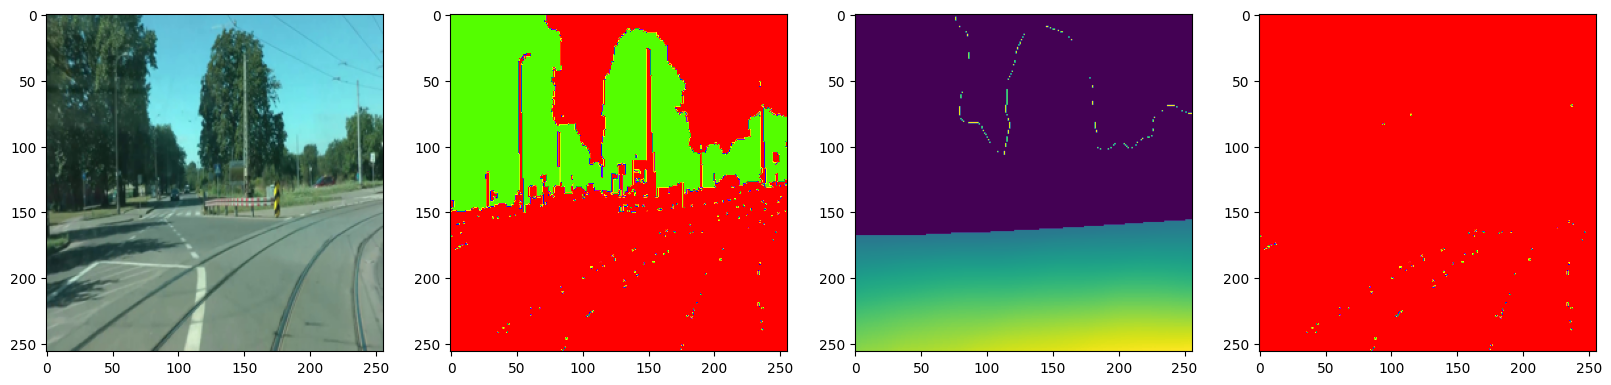

In [6]:
index = 22
figure, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
axis_arr[0].imshow(image_dataset[index])
axis_arr[1].imshow(mask_dataset[index], cmap='prism')
axis_arr[2].imshow(dataset_depth_mask[index])
axis_arr[3].imshow(dataset_mask_multiplied[index], cmap='prism')

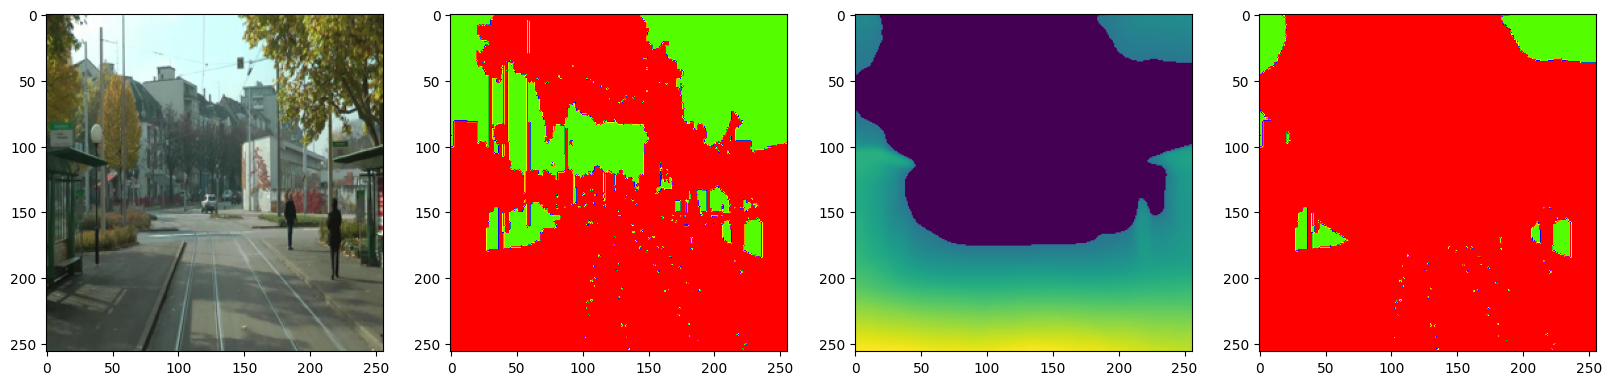

In [69]:
index = 27
f, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
axis_arr[0].imshow(image_dataset[index])
axis_arr[1].imshow(mask_dataset[index], cmap='prism')
axis_arr[2].imshow(dataset_depth_mask[index])
axis_arr[3].imshow(dataset_mask_multiplied[index], cmap='prism')

In [7]:
"""
Why created another dim?
This is due to the requirement of the model.
Now we have [1]/[0] instead of 1/0.
"""
print(dataset_mask_multiplied.shape)
dataset_mask_multiplied = np.expand_dims(dataset_mask_multiplied, axis=3)
print(dataset_mask_multiplied.shape)


(200, 256, 256)
(200, 256, 256, 1)


## Step 4: Split train and test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, dataset_mask_multiplied, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(160, 256, 256, 3)
(40, 256, 256, 3)
(160, 256, 256, 1)
(40, 256, 256, 1)


## Step 5: Build & Fit Model

In [ ]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# define the model
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
#why classes=1 -> read more example
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

In [10]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=10, #back to 10 next time    
                        epochs=20,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/20
16/16 [==============================] - 63s 4s/step - loss: 0.5718 - accuracy: 0.7199 - iou_score: 0.1650 - mse: 1.1121 - val_loss: 4.2660 - val_accuracy: 0.9466 - val_iou_score: 0.0479 - val_mse: 1.5695
Epoch 2/20
16/16 [==============================] - 57s 4s/step - loss: 0.3445 - accuracy: 0.8643 - iou_score: 0.3052 - mse: 1.0185 - val_loss: 12.7576 - val_accuracy: 0.9718 - val_iou_score: 0.0091 - val_mse: 1.5632
Epoch 3/20
16/16 [==============================] - 52s 3s/step - loss: 0.2384 - accuracy: 0.8880 - iou_score: 0.6346 - mse: 0.9810 - val_loss: 11.8764 - val_accuracy: 0.9725 - val_iou_score: 0.0194 - val_mse: 1.5357
Epoch 4/20
16/16 [==============================] - 49s 3s/step - loss: 0.1652 - accuracy: 0.9111 - iou_score: 0.6626 - mse: 0.9558 - val_loss: 3.7094 - val_accuracy: 0.9369 - val_iou_score: 0.4296 - val_mse: 1.4630
Epoch 5/20
16/16 [==============================] - 50s 3s/step - loss: -0.0193 - accuracy: 0.9404 - iou_score: 0.9242 - mse: 0.9162 -

In [11]:
pickle.dump(model, open('model', "wb"))

INFO:tensorflow:Assets written to: ram://6a207a4c-a4b7-4997-a20b-d102d86788a3/assets


INFO:tensorflow:Assets written to: ram://6a207a4c-a4b7-4997-a20b-d102d86788a3/assets


## Step 6: Prediction

index in tets set:  29
1/1 [==============================] - 0s 102ms/step


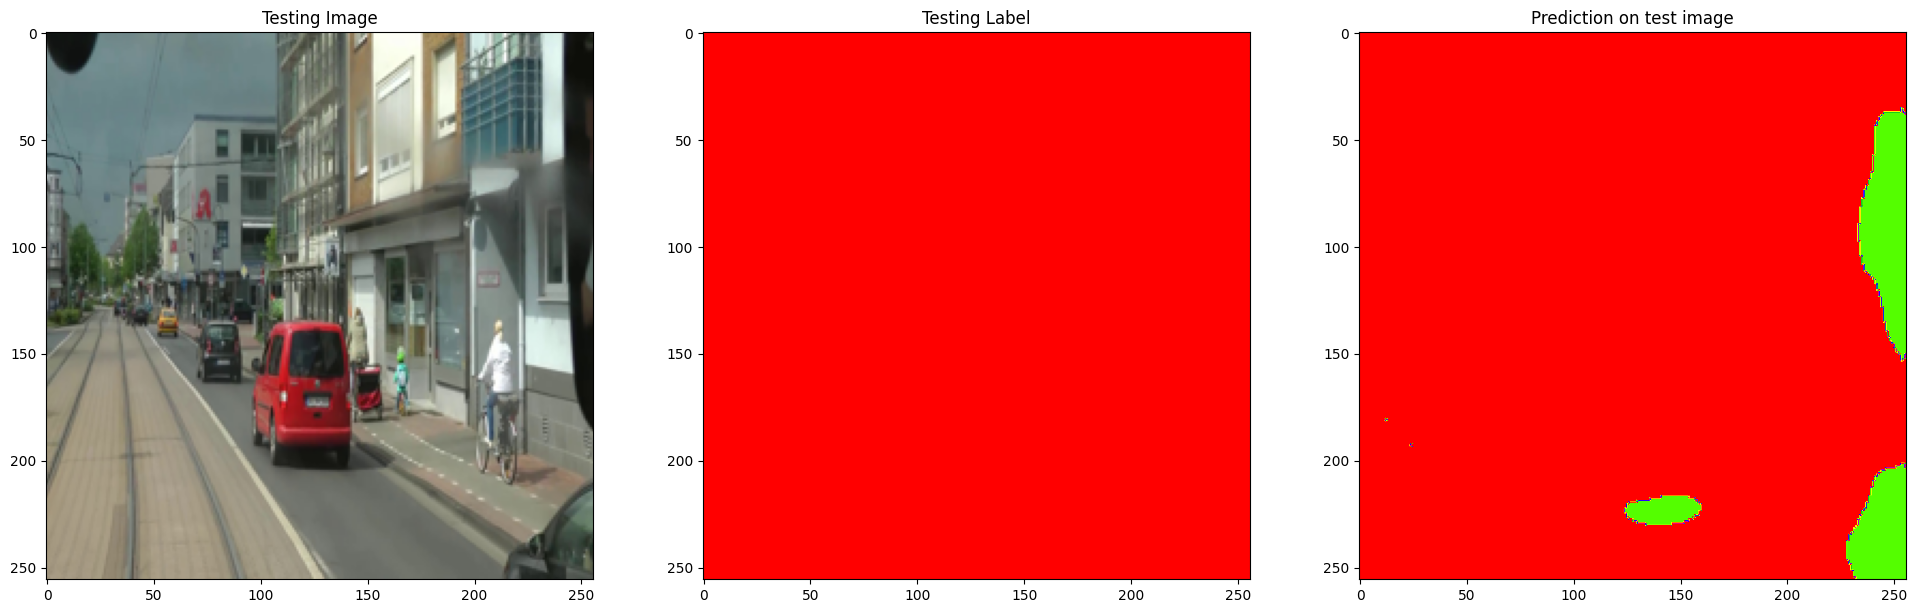

In [71]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

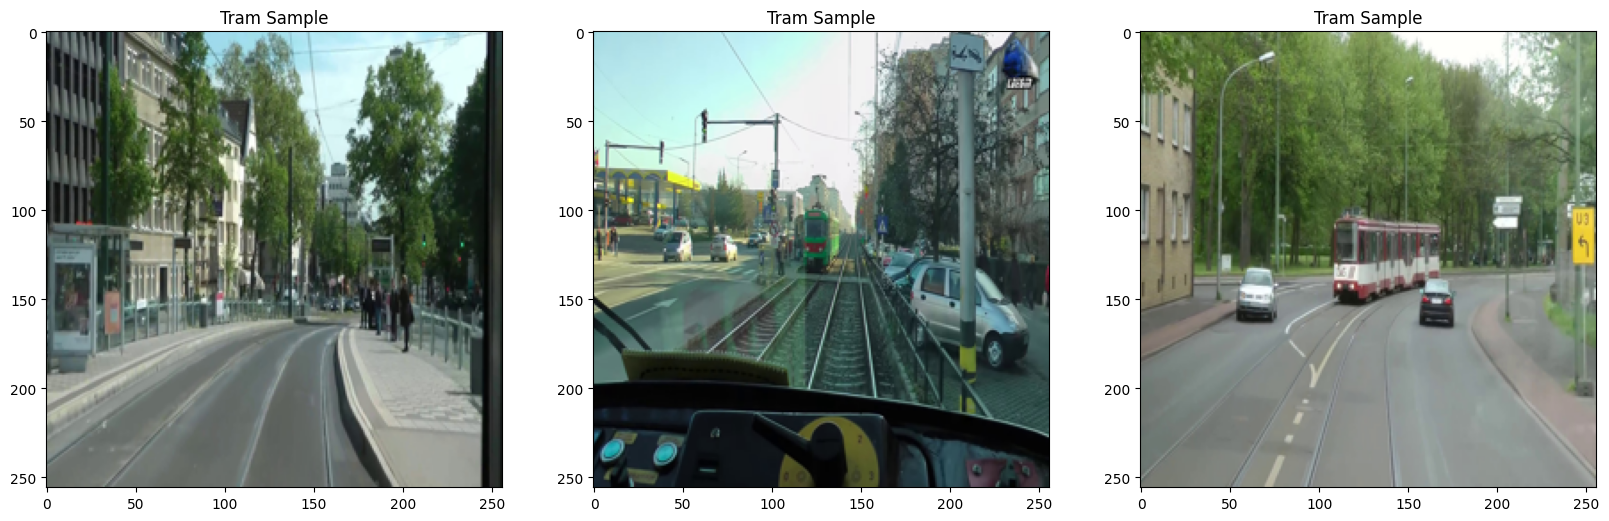

In [26]:
# print some tram pictures
test_img_number = random.randint(0, len(X_test))
test_img_to_show_1 = X_test[test_img_number]
test_img_to_show_2 = X_test[test_img_number+1]
test_img_to_show_3 = X_test[test_img_number+2]
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.title('Tram Sample')
plt.imshow(test_img_to_show_1)

plt.subplot(132)
plt.title('Tram Sample')
plt.imshow(test_img_to_show_2)

plt.subplot(133)
plt.title('Tram Sample')
plt.imshow(test_img_to_show_3)


# Appendix

## Slides materials:

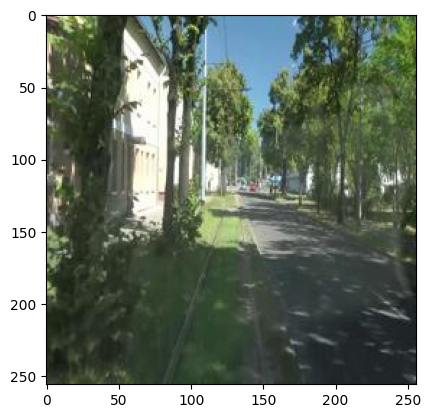

In [ ]:

plt.imshow(Image.open(path_masks_resized+'rs00230.png')

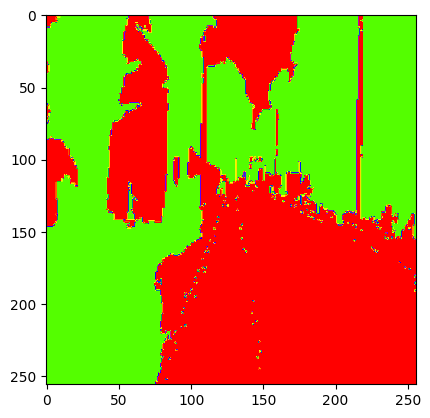

In [ ]:
label_of_interest = 8 #veg
mask = Image.open(path_masks_resized+'rs00230.png')
mask = np.array(mask)
mask[mask!=label_of_interest]=0
plt.imshow(mask, cmap='prism')

In [ ]:
n1 = np.array(mask)
n2 = np.array(dataset_depth_mask[0])
 = n1*n2

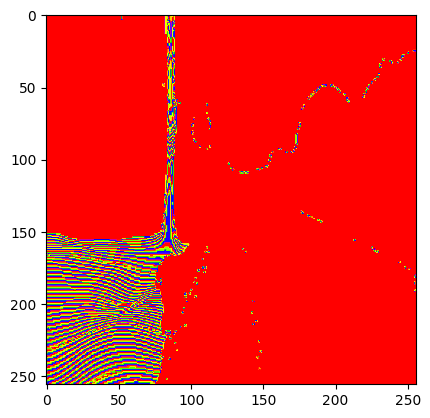

In [ ]:
plt.imshow(n3, cmap='prism')

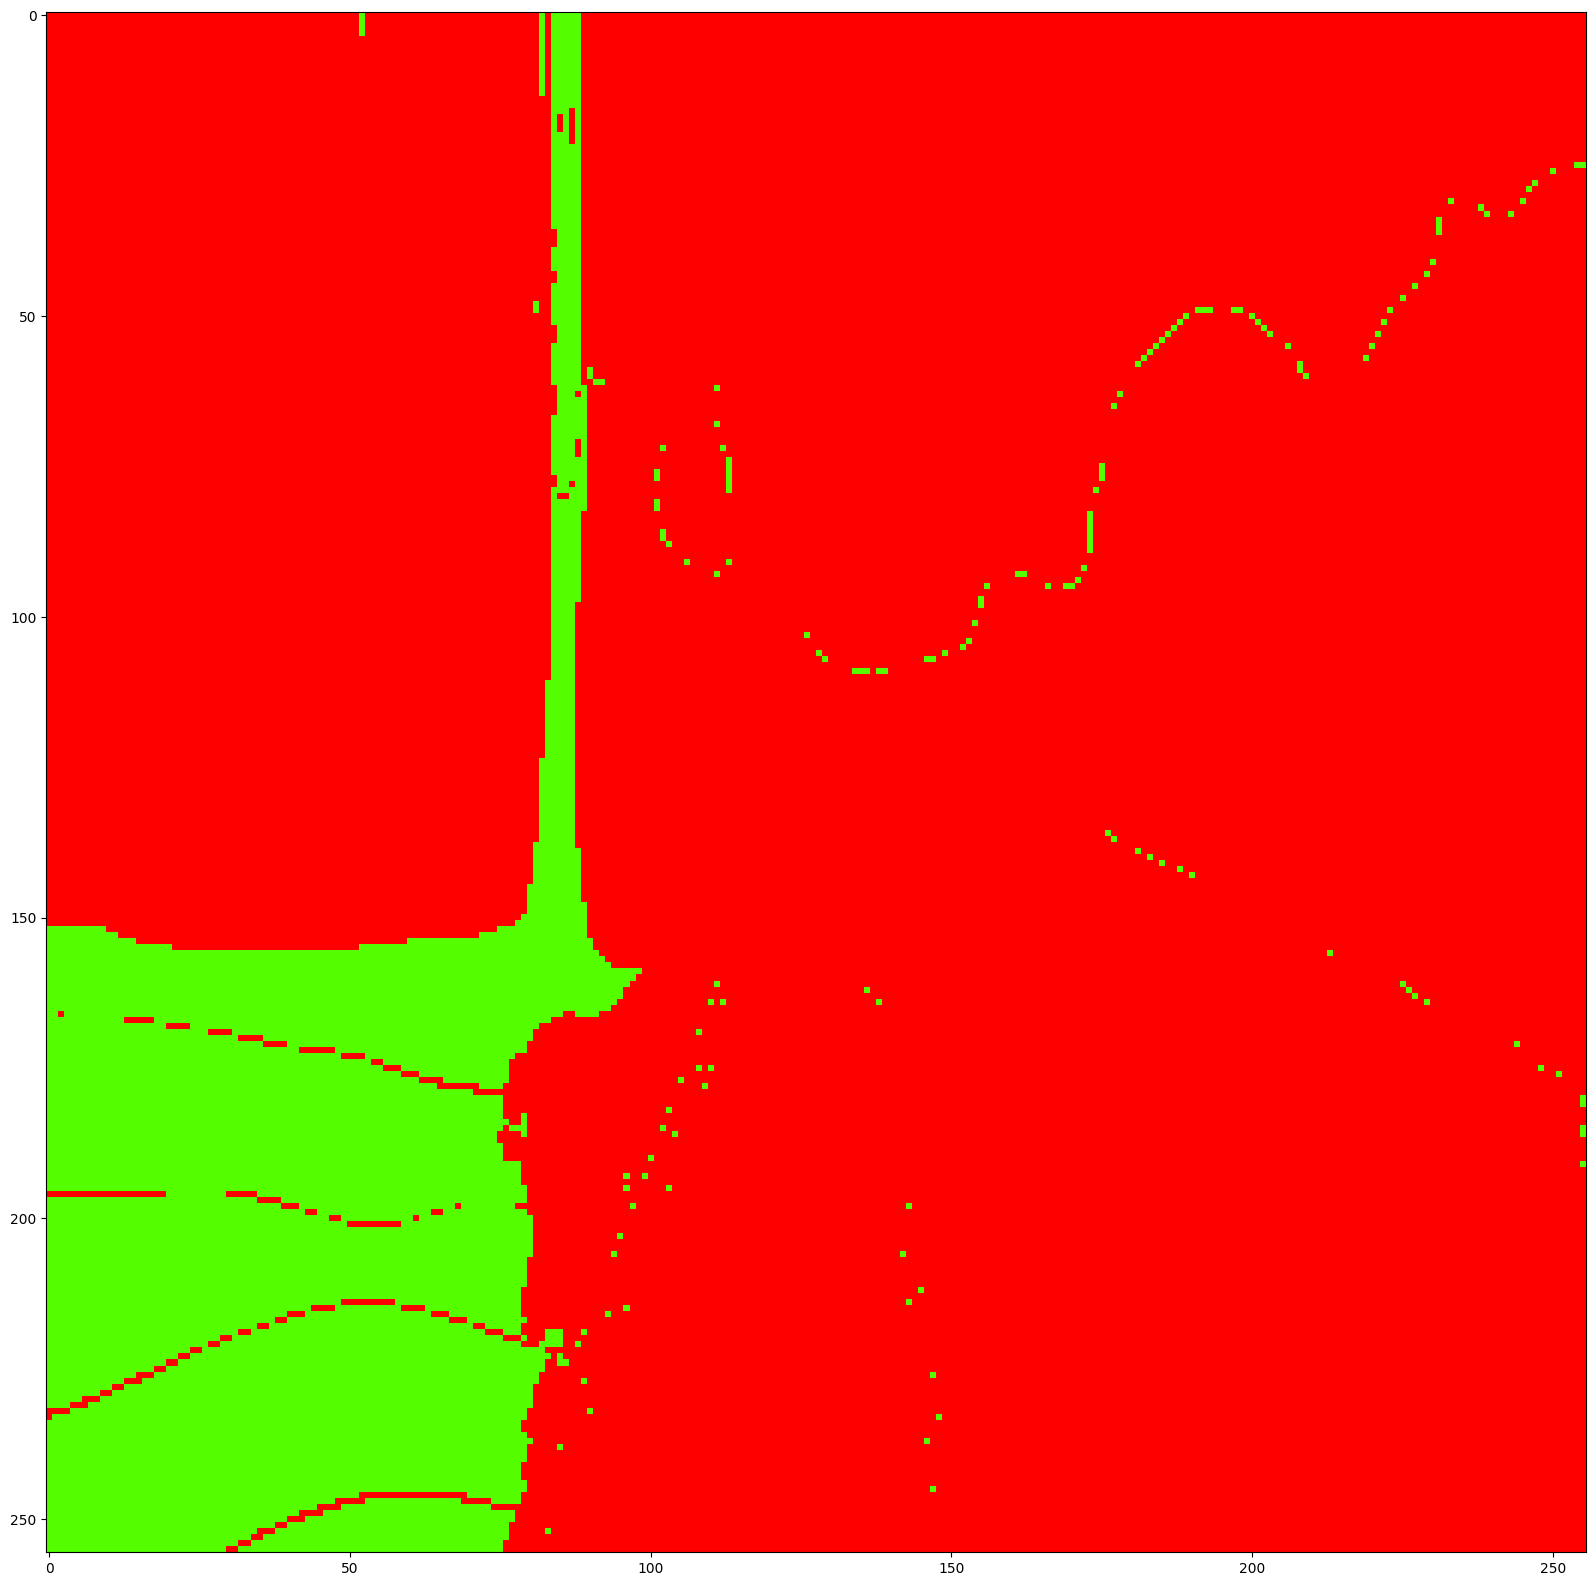

In [ ]:
n3[n3!=0]=8
plt.figure(figsize = (20,20))
plt.imshow(n3, cmap='prism')